<a href="https://colab.research.google.com/github/fahaerte/LSIES-FinalAssignment/blob/main/LSIES_FinalAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set parameters according to execution envirionment:


*   drive --> True if Notebook is executed in the Colab environment
*   install_packages --> Set True if needed
*   In case you are using the colab environment: Specify your path to the helper_func files





In [1]:
drive = False
install_packages = False

In [2]:
if install_packages:
  !pip install Basemap basemap-data-hires
  !pip install pandas matplotlib numpy
  !pip install sklearn
  !pip install datetime

In [3]:
import os
import pandas as pd
import numpy as np
from csv import reader
from sklearn.metrics import r2_score
from datetime import datetime
from datetime import timedelta as tdelta
from datetime import time as time
import warnings

if drive:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Colab\ Notebooks/LSIES

from Helper_funcs import *
from SensorPositions_Func import *
from SVD_Func import *

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

Set some parameters

In [4]:
if drive:
  dir_path = '/content/drive/MyDrive/data/'
else :
  dir_path = './data/'

folders = ['region_1_mustamäe_kristiine', 'region_2_data_kesklinn', 'region_3_kadriorg_lasnamäe', 'region_4_ülemiste']
csv_file_name_sensor_positions = 'sensor_positions.csv'
columns_sensors_positions = ['sensor_name', 'latitude', 'longitude', 'region']

**Task 1: Plot locations of sensors**


In [5]:
sensor_positions_df = import_sensor_positions(dir_path, csv_file_name_sensor_positions)

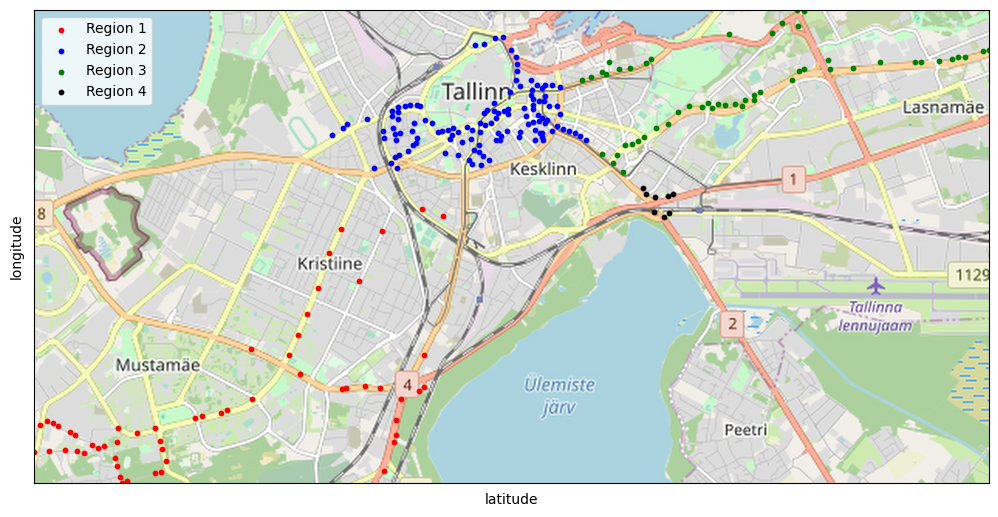

In [6]:
regions = sensor_positions_df['region'].sort_values().unique()
generate_sensor_positions_plot(sensor_positions_df, regions, dir_path + '/map.png')

Number of sensors per region:


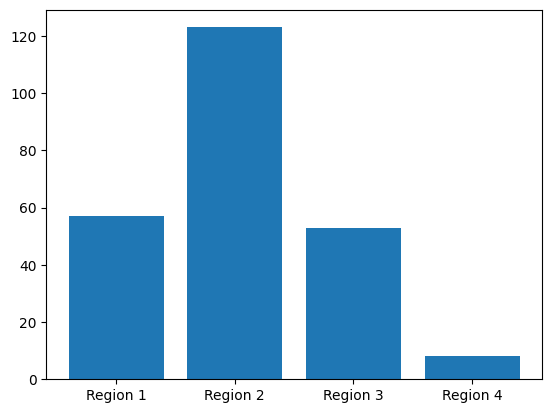

In [7]:
print('Number of sensors per region:')
amount_sensors_per_region = sensor_positions_df.groupby('region')['sensor_name'].count()
regions_strings = ["Region " + str(r) for r in regions]
plt.bar(regions_strings, amount_sensors_per_region)
plt.show()

**Task 2: Interpolation**

Form groups based on distance between stations

In [8]:
sensor_ids = list(sensor_positions_df['sensor_name'])
groups = make_groups(sensor_ids, sensor_positions_df)
sensor_positions_df.insert(loc=1, column='grps', value=groups['grp'])

create groups of sensors based on distance between them


Import sound pressure values

In [9]:
df_data_incomplete = import_sensor_data(dir_path)

Simple interpolation

In [10]:
#interpolate data using 'nearest' method
list_df_other = []
list_df_linear = []
list_df_nearest = []

temp_df = df_data_incomplete.interpolate(method='nearest')
df_data_nearest = temp_df.interpolate(limit_area=None, method='backfill')

temp_df = df_data_incomplete.interpolate(method='linear')
df_data_linear = temp_df.interpolate(limit_area=None, method='backfill')
df_data_linear.apply(lambda x: np.round(x, 1), 1);


In [11]:
# TODO Insert Other interpolation methods

Task 3: SVDs

In [12]:
d = {'sensor names':sensor_positions_df['sensor_name'],'region':sensor_positions_df['region']}
sensors = pd.DataFrame(d)
sensors_region1 = sensors[sensors['region'] == 1]['sensor names']
sensors_region2 = sensors[sensors['region'] == 2]['sensor names']
sensors_region3 = sensors[sensors['region'] == 3]['sensor names']
sensors_region4 = sensors[sensors['region'] == 4]['sensor names']

In [ ]:
# Compute global and regional SVDs
df_without_timestamp = df_data_linear.reset_index().iloc[:, 1:len(df_data_linear.columns)+1]
U_global, s_global, Vt_global = np.linalg.svd(df_without_timestamp)
U_reg1, s_reg1, Vt_reg1 = np.linalg.svd(df_without_timestamp[sensors_region1])
U_reg2, s_reg2, Vt_reg2 = np.linalg.svd(df_without_timestamp[sensors_region2])
U_reg3, s_reg3, Vt_reg3 = np.linalg.svd(df_without_timestamp[sensors_region3])
U_reg4, s_reg4, Vt_reg4 = np.linalg.svd(df_without_timestamp[sensors_region4])

In [ ]:
# Plot RMSE and Singular Values of global SVD
# plot_rmse_sinval_global(U_global, s_global, Vt_global, df_data_linear)

In [ ]:
# Plot RMSE and Singular Values of regional SVDs
# plot_rmse_sinval_regions(df_without_timestamp, sensors_region1, sensors_region2, sensors_region3, sensors_region4)